# Imports

In [1]:
import numpy as onp
import matplotlib.pyplot as plt

In [2]:
%%capture
!pip install jax-md
!pip install optax
!pip install equinox
import jax.numpy as np

In [3]:
%cd ..

/net/fs-brenner01/srv/export/brenner_lab/share/Lab/morphogenesis/jax-morph


In [4]:
from jax import random, vmap
from jax_md import space, quantity 
from jax_morph import datastructures, visualization, cell_division, cell_growth, simulation
from Francesco.chem_twotypes import initial_states, secdiff
from Francesco.chem_twotypes import divrates as divrates_chem
from Ramya.mech_homogeneous_growth import chemical, mechanical, divrates, optimize
from functools import partial
import equinox as eqx

In [5]:
import haiku

In [6]:
# The warnings annoy me :(
import warnings
warnings.filterwarnings('ignore')

In [7]:
%load_ext autoreload
%autoreload 2

# Params

In [8]:
def _maybe_array(name, value, train_params):
    if train_params[name]:
        return np.array(value)
    else:
        return value

In [9]:
#@title Define Params
# Define parameters --blue particles are type 1, orange are type 2
# keep type casting to place vars in gpu memory

# Number of chemical signals
n_chem = 2


### CELL DIMENSIONS
cellRad = .5
cellRadBirth = float(cellRad / np.sqrt(2))


### DIFFUSION

# No diffusion or secretion in my simulation - only external chemical field over positions
diffCoeff = np.ones(n_chem) 
degRate = np.ones(n_chem) 

# diffusion cutoff
r_cutoffDiff = 5.*cellRad
r_onsetDiff = r_cutoffDiff - .5

# CHEMICAL FIELD
chem_max = 100.0
chem_k = 2.0
chem_gamma = 0.4

### SECRETION

# sec rate that gives concentration 1 at source at SS
sec_max_unitary = 2*np.sqrt(diffCoeff*degRate)

sec_max = sec_max_unitary*np.ones((n_chem,), dtype=np.float32)
#sec_max = sec_max.at[0].set(10)

sec_gamma = np.ones((n_chem,n_chem), dtype=np.float32) #was 0.01
sec_k = np.ones((n_chem,n_chem), dtype=np.float32) 
#secreted_by_ctypes = np.ones((n_chem, 1))
ctype_sec_chem = np.ones((1, 2))

# GROWTH

div_gamma = np.append(
    np.array([0.001, -0.001]),
    0.5*np.ones(n_chem)
)
div_k = np.append(
    np.array([-20.0, 20.0]),
    -6.0*np.ones(n_chem)
)


# MORSE POTENTIAL
# always use python scalars
alpha = 3.
eps_TwoTwo = 2. #orange
eps_OneOne = 2. #blue
eps_OneTwo = 2. 

# morse cutoff
r_cutoff = 4.*cellRad
r_onset = r_cutoff - .2


# number of gradient descent steps for Morse potential minimization
mech_relaxation_steps = 10


# Initialization and number of added cells. 
ncells_init = 100 #number of cells in the initial cluster
n_ones_init = 100 #number of type-1 cell in the initail cluster
ncells_add = 100

In [10]:
#@title Define trainable params
train_params = {
    'n_chem': False,
    
    'sec_max': False,
    'sec_gamma': False,
    'sec_k' : False,
    'ctype_sec_chem': False,
    
    'div_gamma' : False,
    'div_k' : False,
    
    'cellRad' : False,
    'cellRadBirth' : False,
    
    'diffCoeff' : True,
    'degRate' : False,
    'r_onsetDiff' : False,
    'r_cutoffDiff' : False,
    
    'alpha': False, 
    'eps_TwoTwo': False, 
    'eps_OneOne' : False,
    'eps_OneTwo' : False,
    'r_onset' : False,
    'r_cutoff' : False,
    'mech_relaxation_steps' : False,
    
    'ncells_init' : False,
    'n_ones_init': False, 
    'ncells_add': False,

    'chem_max': False, 
    'chem_k': False,
    'chem_gamma': False
}

In [11]:
#@title Initialize params
params = {
    'n_chem': n_chem,
    
    'sec_max': sec_max,
    'sec_gamma': sec_gamma,
    'sec_k' : sec_k,
    'ctype_sec_chem' : ctype_sec_chem,
    'div_gamma' : div_gamma,
    'div_k' : div_k,
    
    'cellRad' : cellRad,
    'cellRadBirth' : cellRadBirth,
    
    'diffCoeff' : diffCoeff,
    'degRate' : degRate,
    'r_onsetDiff' : r_onsetDiff,
    'r_cutoffDiff' : r_cutoffDiff,
    
    'alpha': _maybe_array('alpha', alpha, train_params), 
    'eps_TwoTwo': _maybe_array('eps_TwoTwo', eps_TwoTwo, train_params), 
    'eps_OneOne' : _maybe_array('eps_OneOne', eps_OneOne, train_params),
    'eps_OneTwo' : _maybe_array('eps_OneTwo', eps_OneTwo, train_params),
    'r_onset' : r_onset,
    'r_cutoff' : r_cutoff,
    'mech_relaxation_steps' : mech_relaxation_steps,
    
    'ncells_init' : ncells_init,
    'n_ones_init': n_ones_init, 
    'ncells_add': ncells_add,

    'chem_max': chem_max,
    'chem_k': chem_k,
    'chem_gamma': chem_gamma
}

# Set up simulation

In [14]:
key = random.PRNGKey(15)
fspace = datastructures.SpaceFunc(*space.free())
istate = initial_states.init_state_grow(key, params, fspace)
istate = chemical.S_fixed_chemfield(istate, params, fspace)

In [15]:
# init division nn
DIV_HIDDEN = 5
div_init, div_nn_apply = divrates.div_nn(params,train_params=train_params,n_hidden=DIV_HIDDEN,train=True)
params, train_params = div_init(istate, key)

In [16]:
#init secretion nn
SEC_HIDDEN = 5
use_state_fields=datastructures.CellState(*tuple([False]*3+[True]+[False]*4))
sec_init, sec_nn_apply = secdiff.sec_nn(params,train_params,SEC_HIDDEN, train=True, use_state_fields=use_state_fields)
params, train_params = sec_init(istate, key)

In [17]:
fstep = [
    cell_division.S_cell_division,
    cell_growth.S_grow_cells,
    mechanical.S_mechmin_twotypes,
    partial(secdiff.S_ss_chemfield, sec_fn=sec_nn_apply),
    chemical.S_fixed_chemfield,
    divrates.S_set_stress,
    partial(divrates_chem.S_set_divrate, divrate_fn=eqx.filter_jit(div_nn_apply))
]
sim_init, sim_step = simulation.simulation(fstep, params, fspace)

In [18]:
%%time
# run entire simulation
fstate, state_all = simulation.sim_trajectory(istate, sim_init, sim_step, key=key, history=True)

CPU times: user 1.93 s, sys: 268 ms, total: 2.2 s
Wall time: 2.69 s


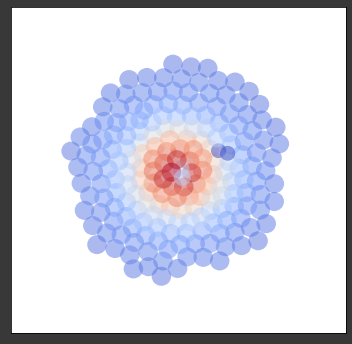

In [19]:
visualization.draw_circles_divrate(fstate)

# Scaled Gradient

In [20]:
import jax_md.dataclasses as jax_dataclasses

In [21]:
# Scaling params: 
# Want to reach 50/e at about 4 units
# Every time cell divides, adds about 0.03 units 
def S_scaled_chemfield(state,
                  params,
                  fspace,
                  noise=0.0,
                  **kwargs 
                  ) -> datastructures.CellState:
    """
  Fixed morphogen field based on particle position from center cell.
  Arg:
    state: current state
    param: dictionary with parameters
  Returns:
    big_state_output: CellState with updated chemical concentration
  """
    # Find displacements from center of cluster.
    center = np.array([0.0, 0.0])
    num_cells = np.count_nonzero(state.celltype)
    chemfield_disp = vmap(fspace.displacement, (0, None))(state.position, center)
    chemfield_disp = np.linalg.norm(chemfield_disp, axis=1)
    chemfield = 50*np.exp(-chemfield_disp/(0.03*num_cells))
    chemfield = np.where(state.celltype > 0, chemfield, 0.0) + noise*random.normal(state.key, chemfield.shape)
    state = jax_dataclasses.replace(state, field=chemfield)
    return state

In [22]:
fstep = [
    cell_division.S_cell_division,
    cell_growth.S_grow_cells,
    mechanical.S_mechmin_twotypes,
    partial(secdiff.S_ss_chemfield, sec_fn=sec_nn_apply),
    S_scaled_chemfield,
    divrates.S_set_stress,
    partial(divrates_chem.S_set_divrate, divrate_fn=eqx.filter_jit(div_nn_apply))
]
sim_init, sim_step = simulation.simulation(fstep, params, fspace)

In [23]:
istate = S_scaled_chemfield(istate, params, fspace)
fstate, state_all = simulation.sim_trajectory(istate, sim_init, sim_step, key=key, history=True)

<AxesSubplot:>

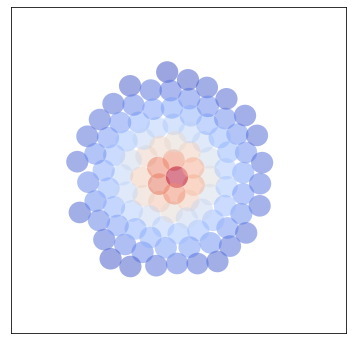

In [24]:
visualization.draw_circles(istate, istate.field)

<AxesSubplot:>

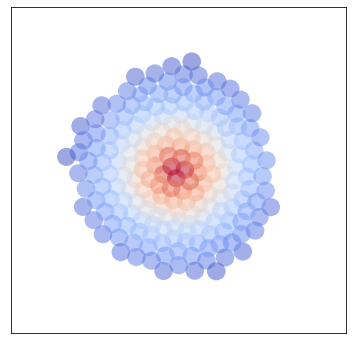

In [25]:
visualization.draw_circles(fstate, fstate.field)

# Optimization

In [26]:
import optax
from jax import value_and_grad, lax
from Ramya.mech_homogeneous_growth.optimize import avg_loss

In [27]:
use_state_fields_sec=datastructures.CellState(*tuple([False]*3+[True]+[False]*4))
use_state_fields_div=datastructures.CellState(*tuple([False]*3+[True, False]+[False, True, False]))
sec_init, sec_nn_apply = secdiff.sec_nn(params,train_params,SEC_HIDDEN, use_state_fields=use_state_fields_sec, train=True)
div_init, div_nn_apply = divrates.div_nn(params,train_params=train_params,n_hidden=DIV_HIDDEN, use_state_fields=use_state_fields_div, train=True)
params, train_params = sec_init(istate, key)
params, train_params = div_init(istate, key)
train_params["diffCoeff"] = True

In [28]:
fstep = [
    cell_division.S_cell_division,
    cell_growth.S_grow_cells,
    mechanical.S_mechmin_twotypes,
    partial(secdiff.S_ss_chemfield, sec_fn=sec_nn_apply),
    S_scaled_chemfield,
    divrates.S_set_stress,
    partial(divrates_chem.S_set_divrate, divrate_fn=eqx.filter_jit(div_nn_apply))
]

In [109]:
%%time
params_t, loss_t, grads_t = optimize.optimize(key, 2, 2, 0.01, params, train_params, fstep, fspace, istate, opt_type="combined")

loss: 0.112698264, reinforce: -5.084207
loss: 0.09863188, reinforce: -4.475855
CPU times: user 11.4 s, sys: 2.27 s, total: 13.7 s
Wall time: 18.4 s


Will have to use loss at every time step for this - otherwise it could just overfit to the field at the last timestep

In [29]:
@eqx.filter_jit
@eqx.filter_vmap(default=None, kwargs=dict(sim_key=0))
def shape_loss_fr(params, 
            hyper_params,
            fstep,
            fspace,
            istate,
            sim_key=None,
            metric_fn=None,
            target_metric=0.,
            REINFORCE=True,
            GAMMA=.95,
            TEST=False,
           ):
    '''
    REINFORCE loss with discounting.  
    '''
    
    def _sim_trajectory(istate, sim_init, sim_step, ncells_add, key=None):

        state = sim_init(istate, ncells_add, key)

        def scan_fn(state, i):
            state, logp = sim_step(state)
            loss = np.sum((metric_fn(state) - target_metric)**2)
            loss = np.sqrt(loss)
            return state, (logp, loss)


        iterations = len(state.celltype)-len(istate.celltype)
        iterations = np.arange(iterations)
        fstate, aux = lax.scan(scan_fn, state, iterations)

        return fstate, aux

    # merge params dicts
    all_params = eqx.combine(params, hyper_params)
    
    #simulation length
    ncells_add = all_params['ncells_add']


    #forward pass - simulation
    sim_init, sim_step = simulation.simulation(fstep, all_params, fspace)
    fstate, (logp, losses) = _sim_trajectory(istate, sim_init, sim_step, ncells_add, sim_key)


    
    if REINFORCE:
        
        def _returns_rec(losses):
            Gs=[]
            G=0
            i=0
            for l in losses[::-1]:
                G = l+G*GAMMA
                Gs.append(G)
                i += 1

            return np.array(Gs)[::-1]
        
        iloss = np.sqrt(np.sum((metric_fn(istate) - target_metric)**2))
        rewards = -np.diff(np.append(np.array([iloss]),losses))
        
        #discount rewards
        returns = _returns_rec(rewards)
        
        loss = -np.sum(logp*lax.stop_gradient(returns))#+rewards.sum()
        
        return loss
    
    if TEST:
        return losses, rewards, logp

    else:
        return losses[-1]

In [121]:
EPOCHS = 20
EPISODES_PER_UPDATE = 20 #128
EPISODES_PER_EVAL = 20 #128
LEARNING_RATE = 0.01
METRIC_FN = optimize.cv_divrates
TARGET_METRIC = 0.0


rloss = partial(shape_loss_fr, metric_fn=METRIC_FN, target_metric=TARGET_METRIC, REINFORCE=True)
sloss = partial(shape_loss_fr, metric_fn=METRIC_FN, target_metric=TARGET_METRIC, REINFORCE=False)
p, hp = eqx.partition(params, train_params)

# init optimizer
optimizer = optax.chain(optax.clip_by_global_norm(1.0), optax.adam(LEARNING_RATE)) 
opt_state = optimizer.init(p)


#--------------------------------------------
#store loss at initial params and calc grad 

key, *batch_subkeys = random.split(key, EPISODES_PER_UPDATE+1)
batch_subkeys = np.array(batch_subkeys)
ll, grads = value_and_grad(avg_loss)(p, hp, rloss, batch_subkeys, fstep=fstep, fspace=fspace, istate=istate)
key, *eval_subkeys = random.split(key, EPISODES_PER_EVAL+1)
eval_subkeys = np.array(eval_subkeys)
l = avg_loss(p, hp, sloss, eval_subkeys, fstep=fstep, fspace=fspace, istate=istate)

#store initial params and loss
loss_t = [float(l)]
params_t = [p]

#--------------------------------------------


for t in range(EPOCHS):
    
    #generate batch of random keys
    key, *batch_subkeys = random.split(key, EPISODES_PER_UPDATE+1)
    batch_subkeys = np.array(batch_subkeys)
    # sgd step
    updates, opt_state = optimizer.update(grads, opt_state, p)

    p = eqx.apply_updates(p, updates)
    
    if None != p['diffCoeff']:
        p['diffCoeff'] = np.where(p['diffCoeff']>.2,p['diffCoeff'],.2)
    
    #estimate actual avg loss
    key, *eval_subkeys = random.split(key, EPISODES_PER_EVAL+1)
    eval_subkeys = np.array(eval_subkeys)

    l = avg_loss(p, hp, sloss, eval_subkeys, fstep=fstep, fspace=fspace, istate=istate)    
    # surrogate loss and grads
    ll, grads = value_and_grad(avg_loss)(p, hp, rloss, batch_subkeys, fstep=fstep, fspace=fspace, istate=istate)
    #store
    loss_t += [float(l)]
    params_t += [p]
    #grads_t += [grads]
    print(float(l))

0.32165637612342834
0.26564571261405945
0.22692671418190002
0.18532030284404755
0.16923196613788605
0.1735178828239441
0.19001702964305878
0.21717122197151184
0.233101949095726
0.2512989044189453
0.26208004355430603
0.2801085114479065
0.2865981459617615
0.28887882828712463
0.273320734500885
0.25670287013053894
0.23386617004871368
0.2226174920797348
0.20770815014839172
0.1869986355304718


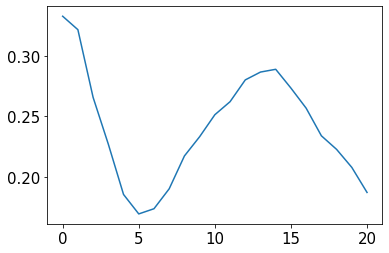

In [122]:
plt.plot(loss_t)

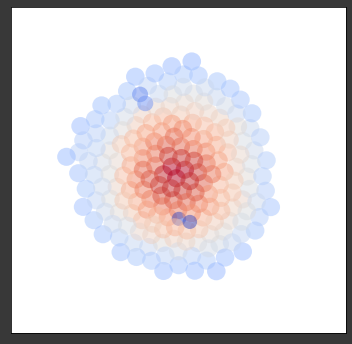

In [123]:
visualization.draw_circles_divrate(fstate)

In [131]:
opt_params = eqx.combine(params_t[-1], params)
sim_init, sim_step = simulation.simulation(fstep, opt_params, fspace)
# run entire simulation
fstate_opt, state_all_opt = simulation.sim_trajectory(istate, sim_init, sim_step, key=key, history=True)

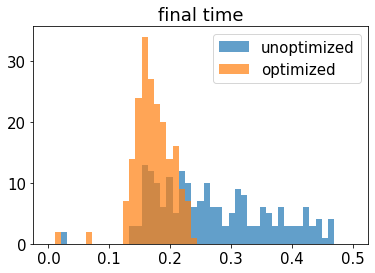

In [141]:
plt.hist(fstate.divrate.tolist(), bins=np.linspace(0.0, 0.5, 50), label="unoptimized", alpha=0.7)
plt.hist(fstate_opt.divrate.tolist(), bins=np.linspace(0.0, 0.5, 50), label="optimized", alpha=0.7)
plt.legend();
plt.title("final time");

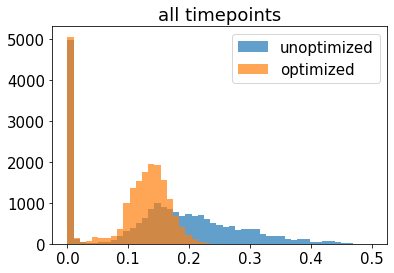

In [140]:
plt.hist(state_all[0].divrate.flatten().tolist(), bins=np.linspace(0.0, 0.5, 50), label="unoptimized", alpha=0.7)
plt.hist(state_all_opt[0].divrate.flatten().tolist(), bins=np.linspace(0.0, 0.5, 50), label="optimized", alpha=0.7)
plt.legend();
plt.title("all timepoints");

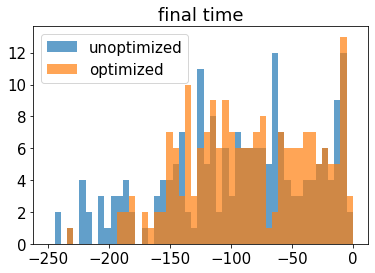

In [144]:
plt.hist(fstate.stress.tolist(), label="unoptimized", alpha=0.7, bins=np.linspace(-250, 0, 50))
plt.hist(fstate_opt.stress.tolist(), label="optimized", alpha=0.7, bins=np.linspace(-250, 0, 50))
plt.legend();
plt.title("final time");

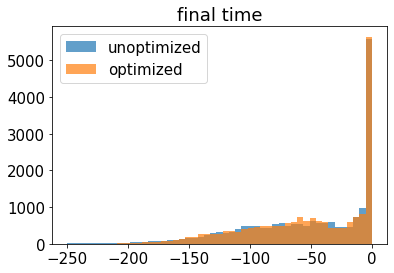

In [146]:
plt.hist(state_all[0].stress.flatten().tolist(), label="unoptimized", alpha=0.7, bins=np.linspace(-250, 0, 50))
plt.hist(state_all_opt[0].stress.flatten().tolist(), label="optimized", alpha=0.7, bins=np.linspace(-250, 0, 50))
plt.legend();
plt.title("final time");

In [155]:
state_all_opt[0].chemical[:, :, 1].shape

(100, 200)

In [163]:
import seaborn as sns

In [170]:
stresses = np.tile(np.linspace(-250, -10, 20), 20)
chemicals_one = np.vstack((np.repeat(np.linspace(0.0, 20.0, 20), 20), 
                           5.0*np.ones(400))).T
chemicals_two = np.vstack((3.0*np.ones(400), 
                           np.repeat(np.linspace(0.0, 20.0, 20), 20))).T
chemicals_all = np.vstack((np.tile(np.linspace(0.0, 20.0, 20), 20), 
                           np.repeat(np.linspace(0.0, 30.0, 20), 20))).T

In [145]:
# generate fake cell state to test output of network on different stress values
def fake_cell_state(stresses, chemicals, N=400):    
    celltype = np.ones(N, dtype=np.int16)
    radius = np.ones(N, dtype=np.float32)    
    position = np.zeros((N,2), dtype=np.float32)
    field = np.zeros(N, dtype=np.float32)
    divrate = np.zeros(N, dtype=np.float32)
    fake_state = datastructures.CellState(position, celltype, radius, chemicals, field, divrate, stresses, key)
    return fake_state

In [173]:
state_one = fake_cell_state(stresses, chemicals_one, 400)
state_two = fake_cell_state(stresses, chemicals_two, 400)
state_all = fake_cell_state(np.ones(400)*-100.0, chemicals_all, 400)

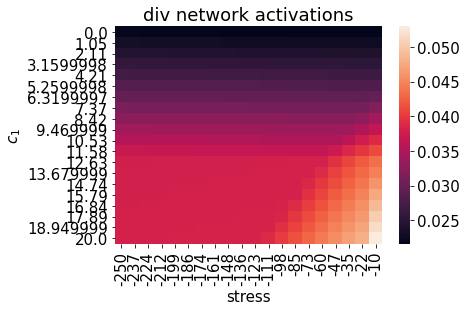

In [174]:
outputs_one = div_nn_apply(state_one, opt_params)
sns.heatmap(outputs_one.reshape(20,20), xticklabels=np.linspace(-250, -10, 20).astype(int), yticklabels=np.around(np.linspace(0.0, 20.0, 20), decimals=2))
plt.xlabel("stress")
plt.ylabel("$c_1$");
plt.title('div network activations');

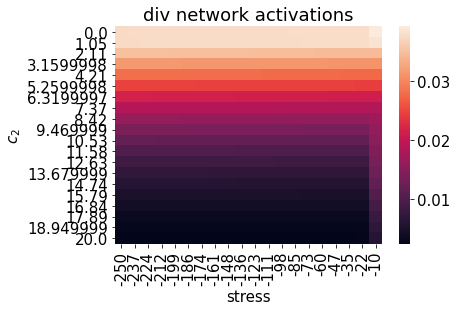

In [175]:
outputs_two = div_nn_apply(state_two, opt_params)
sns.heatmap(outputs_two.reshape(20,20), xticklabels=np.linspace(-250, -10, 20).astype(int), yticklabels=np.around(np.linspace(0.0, 20.0, 20), decimals=2))
plt.xlabel("stress")
plt.ylabel("$c_2$");
plt.title('div network activations');

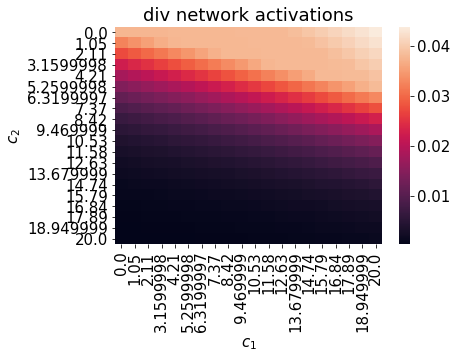

In [176]:
outputs_all = div_nn_apply(state_all, opt_params)
sns.heatmap(outputs_all.reshape(20,20), xticklabels=np.around(np.linspace(0.0, 20.0, 20), decimals=2), yticklabels=np.around(np.linspace(0.0, 20.0, 20), decimals=2))
plt.xlabel("$c_1$")
plt.ylabel("$c_2$");
plt.title('div network activations');

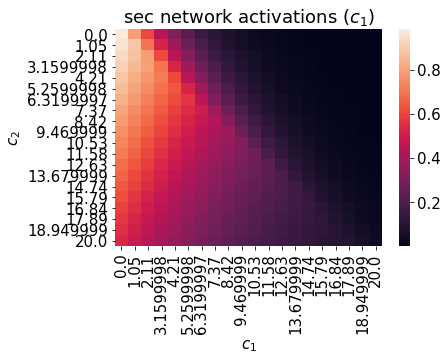

In [177]:
outputs_all = sec_nn_apply(state_all, opt_params)
sns.heatmap(outputs_all[:, 0].reshape(20,20), xticklabels=np.around(np.linspace(0.0, 20.0, 20), decimals=2), yticklabels=np.around(np.linspace(0.0, 20, 20), decimals=2))
plt.xlabel("$c_1$")
plt.ylabel("$c_2$");
plt.title('sec network activations ($c_1$)');

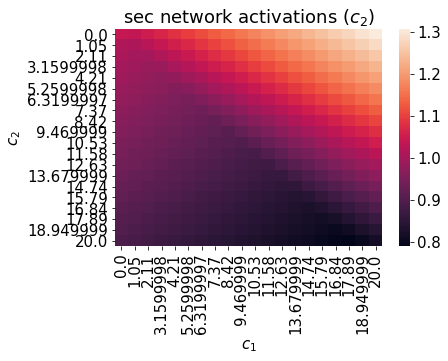

In [178]:
outputs_all = sec_nn_apply(state_all, opt_params)
sns.heatmap(outputs_all[:, 1].reshape(20,20), xticklabels=np.around(np.linspace(0.0, 20.0, 20), decimals=2), yticklabels=np.around(np.linspace(0.0, 20, 20), decimals=2))
plt.xlabel("$c_1$")
plt.ylabel("$c_2$");
plt.title('sec network activations ($c_2$)');

In [30]:
def chemical_loss(state):
    center = np.array([0.0, 0.0])
    num_cells = np.count_nonzero(state.celltype)
    chemfield_disp = vmap(fspace.displacement, (0, None))(state.position, center)
    chemfield_disp = np.linalg.norm(chemfield_disp, axis=1)
    chemfield = 50*np.exp(-chemfield_disp/(0.03*num_cells))
    chemfield = np.where(state.celltype > 0, chemfield, 0.0) #+ noise*random.normal(state.key, chemfield.shape)
    return state.chemical[:, 0] - chemfield

In [31]:
use_state_fields_sec=datastructures.CellState(*tuple([False]*3+[True]+[False]*4))
use_state_fields_div=datastructures.CellState(*tuple([False]*3+[True, False]+[False, True, False]))
sec_init, sec_nn_apply = secdiff.sec_nn(params,train_params,SEC_HIDDEN, use_state_fields=use_state_fields_sec, train=True)
div_init, div_nn_apply = divrates.div_nn(params,train_params=train_params,n_hidden=DIV_HIDDEN, use_state_fields=use_state_fields_div, train=False)
params, train_params = sec_init(istate, key)
params, train_params = div_init(istate, key)
train_params["diffCoeff"] = True

In [32]:
EPOCHS = 100
EPISODES_PER_UPDATE = 20 #128
EPISODES_PER_EVAL = 20 #128
LEARNING_RATE = 0.01
METRIC_FN = chemical_loss
TARGET_METRIC = 0.0


rloss = partial(shape_loss_fr, metric_fn=METRIC_FN, target_metric=TARGET_METRIC, REINFORCE=True)
sloss = partial(shape_loss_fr, metric_fn=METRIC_FN, target_metric=TARGET_METRIC, REINFORCE=False)
p, hp = eqx.partition(params, train_params)

# init optimizer
optimizer = optax.chain(optax.clip_by_global_norm(1.0), optax.adam(LEARNING_RATE)) 
opt_state = optimizer.init(p)


#--------------------------------------------
#store loss at initial params and calc grad 

key, *batch_subkeys = random.split(key, EPISODES_PER_UPDATE+1)
batch_subkeys = np.array(batch_subkeys)
ll, grads = value_and_grad(avg_loss)(p, hp, sloss, batch_subkeys, fstep=fstep, fspace=fspace, istate=istate)
key, *eval_subkeys = random.split(key, EPISODES_PER_EVAL+1)
eval_subkeys = np.array(eval_subkeys)
l = avg_loss(p, hp, sloss, eval_subkeys, fstep=fstep, fspace=fspace, istate=istate)

#store initial params and loss
loss_t = [float(l)]
params_t = [p]
grads_t = [grads]
#--------------------------------------------


for t in range(EPOCHS):
    
    #generate batch of random keys
    key, *batch_subkeys = random.split(key, EPISODES_PER_UPDATE+1)
    batch_subkeys = np.array(batch_subkeys)
    # sgd step
    updates, opt_state = optimizer.update(grads, opt_state, p)

    p = eqx.apply_updates(p, updates)
    
    if None != p['diffCoeff']:
        p['diffCoeff'] = np.where(p['diffCoeff']>.2,p['diffCoeff'],.2)
    
    #estimate actual avg loss
    key, *eval_subkeys = random.split(key, EPISODES_PER_EVAL+1)
    eval_subkeys = np.array(eval_subkeys)

    l = avg_loss(p, hp, sloss, eval_subkeys, fstep=fstep, fspace=fspace, istate=istate)    
    # surrogate loss and grads
    ll, grads = value_and_grad(avg_loss)(p, hp, sloss, batch_subkeys, fstep=fstep, fspace=fspace, istate=istate)
    #store
    loss_t += [float(l)]
    params_t += [p]
    grads_t += [grads]
    print(float(l))

358.7676696777344
359.9001159667969
354.9317321777344
353.68756103515625
352.1861877441406
350.539306640625
347.1710510253906
344.9371032714844
342.72760009765625
340.2776184082031
338.0755310058594
335.816162109375
333.4884033203125
332.0360107421875
329.8077697753906
328.0003967285156
325.8351745605469
324.03228759765625
322.178466796875
320.75018310546875
318.5455322265625
317.22174072265625
315.14276123046875
313.8866882324219
312.2558898925781
310.2412109375
308.9407958984375
307.5954895019531
305.9351501464844
304.0627136230469
302.5683288574219
300.8980407714844
299.0796813964844
296.8551940917969
294.7492370605469
292.3343811035156
289.9580078125
287.2639465332031
284.39776611328125
281.4463806152344
278.29681396484375
275.0509948730469
271.4888610839844
268.3542785644531
264.9432678222656
261.27935791015625
258.2079772949219
254.68972778320312
252.27427673339844
249.33438110351562
246.8154754638672
244.23635864257812
242.5858917236328
240.46800231933594
238.8440399169922
237.4

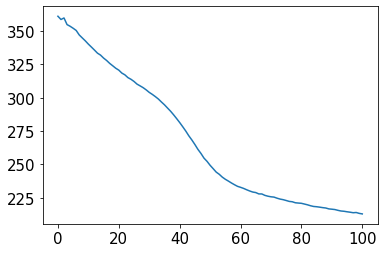

In [34]:
plt.plot(loss_t)

In [35]:
opt_params = eqx.combine(params_t[-1], params)
sim_init, sim_step = simulation.simulation(fstep, opt_params, fspace)
# run entire simulation
fstate_opt, state_all_opt = simulation.sim_trajectory(istate, sim_init, sim_step, key=key, history=True)

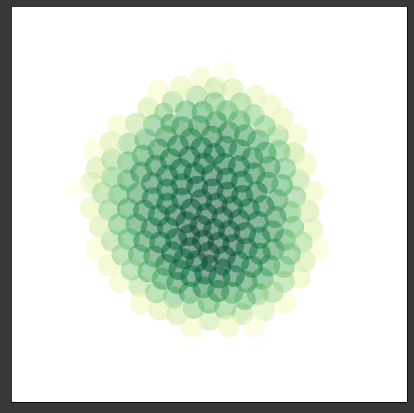

In [36]:
visualization.draw_circles_chem(fstate);

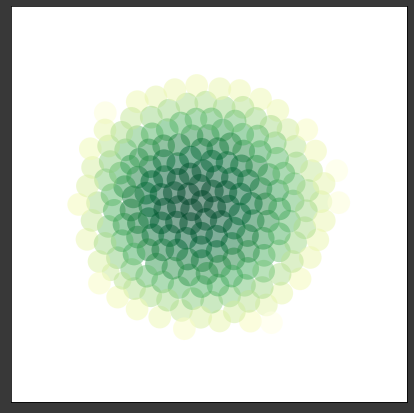

In [37]:
visualization.draw_circles_chem(fstate_opt);

In [126]:
def plot_field(state_position, state_chemical, color):
    center = np.array([0.0, 0.0])
    chemfield_disp = vmap(fspace.displacement, (0, None))(state_position, center)
    chemfield_disp = np.linalg.norm(chemfield_disp, axis=1)
    sorted_list = np.array(sorted(zip(chemfield_disp, state_chemical), key=lambda x: x[0]))
    plt.plot(sorted_list[:, 0], sorted_list[:, 1], c=color)

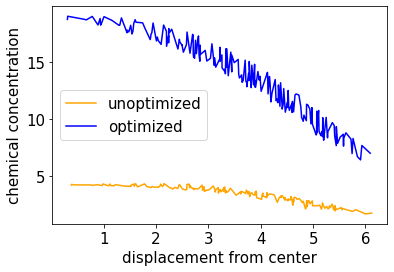

In [127]:
plot_field(fstate.position, fstate.chemical[:, 0], 'orange');
plot_field(fstate_opt.position, fstate_opt.chemical[:, 0], 'blue');
plt.xlabel("displacement from center")
plt.ylabel("chemical concentration")
plt.legend(["unoptimized", "optimized"]);

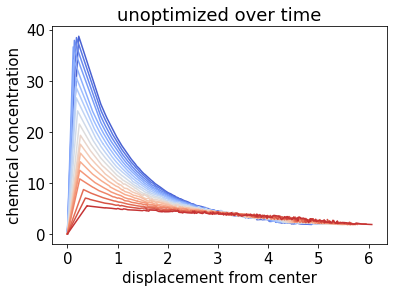

In [131]:
for i in range(5, len(state_all[0].position), 5):
    plot_field(state_all[0].position[i], state_all[0].chemical[i, :, 0], plt.cm.coolwarm(i/len(state_all_opt[0].position)));
plt.xlabel("displacement from center")
plt.ylabel("chemical concentration")
plt.title("unoptimized over time");

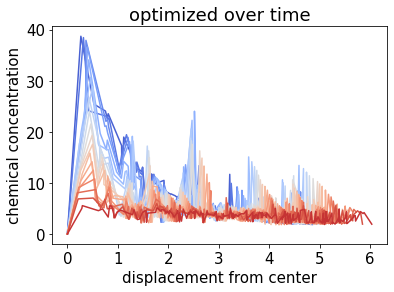

In [132]:
for i in range(5, len(state_all_opt[0].position), 5):
    plot_field(state_all_opt[0].position[i], state_all[0].chemical[i, :, 0], plt.cm.coolwarm(i/len(state_all_opt[0].position)));
plt.xlabel("displacement from center")
plt.ylabel("chemical concentration")
plt.title("optimized over time");

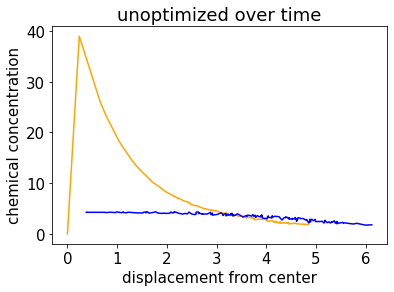

In [135]:
plot_field(state_all[0].position[3], state_all[0].chemical[3, :, 0], 'orange');
plot_field(state_all[0].position[-1], state_all[0].chemical[-1, :, 0], 'blue');
plt.xlabel("displacement from center")
plt.ylabel("chemical concentration")
plt.title("unoptimized over time");

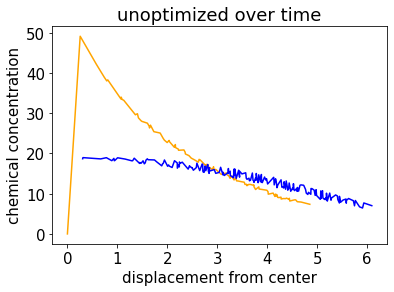

In [136]:
plot_field(state_all_opt[0].position[3], state_all_opt[0].chemical[3, :, 0], 'orange');
plot_field(state_all_opt[0].position[-1], state_all_opt[0].chemical[-1, :, 0], 'blue');
plt.xlabel("displacement from center")
plt.ylabel("chemical concentration")
plt.title("unoptimized over time");

In [137]:
def make_cell_state(traj, idx):
    state = datastructures.CellState(traj.position[idx],
                                    traj.celltype[idx],
                                    traj.radius[idx],
                                    traj.chemical[idx],
                                    traj.field[idx],
                                    traj.divrate[idx],
                                    traj.stress[idx],
                                    traj.key)
    return state

<AxesSubplot:>

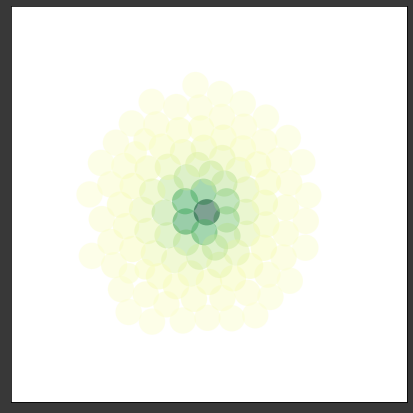

In [138]:
visualization.draw_circles_chem(make_cell_state(state_all[0], 3))

<AxesSubplot:>

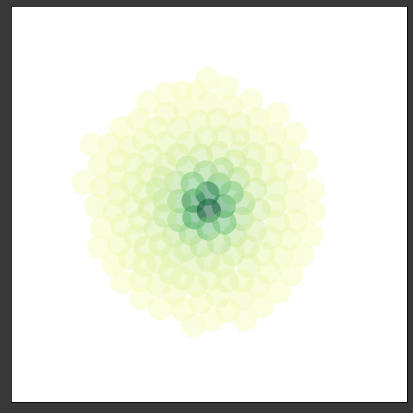

In [139]:
visualization.draw_circles_chem(make_cell_state(state_all[0], 50))

<AxesSubplot:>

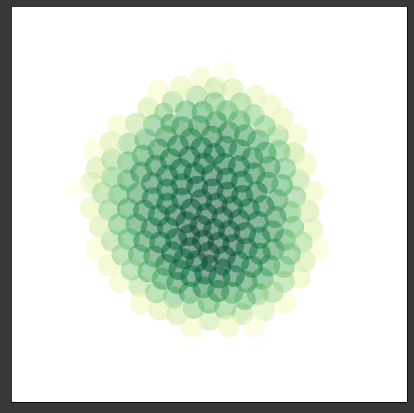

In [140]:
visualization.draw_circles_chem(make_cell_state(state_all[0], 100))

<AxesSubplot:>

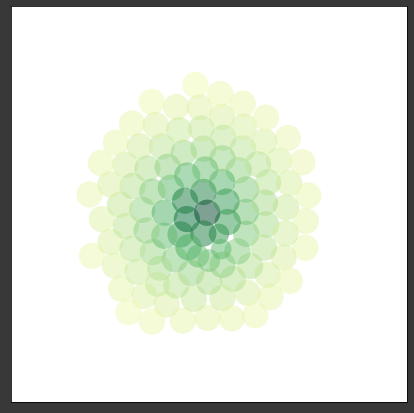

In [141]:
visualization.draw_circles_chem(make_cell_state(state_all_opt[0], 3))

<AxesSubplot:>

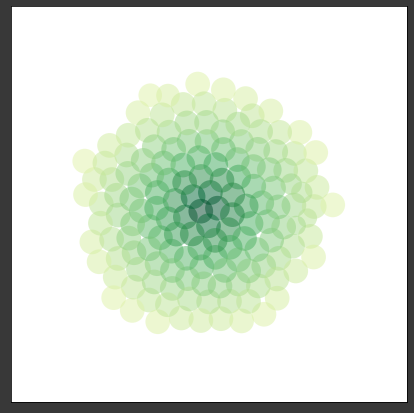

In [142]:
visualization.draw_circles_chem(make_cell_state(state_all_opt[0], 50))

<AxesSubplot:>

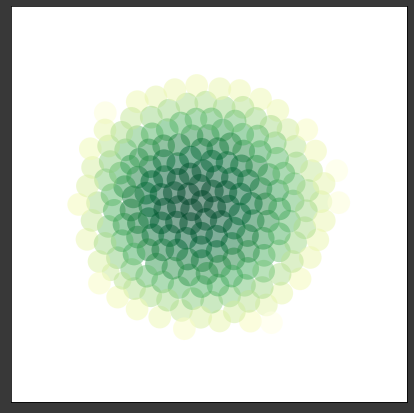

In [143]:
visualization.draw_circles_chem(make_cell_state(state_all_opt[0], 100))

In [156]:
import seaborn as sns
chemicals_all = np.vstack((np.tile(np.linspace(9, 12.0, 20), 20), 
                           np.repeat(np.linspace(4.0, 9.0, 20), 20))).T

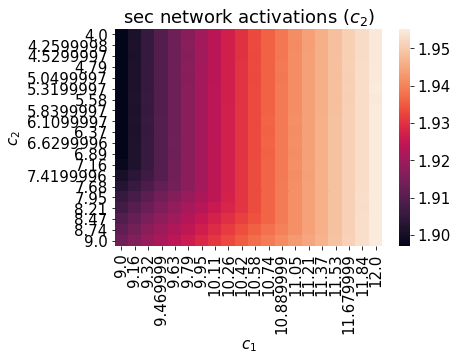

In [157]:
stresses = np.tile(np.linspace(-250, -10, 20), 20)
state_all = fake_cell_state(stresses, chemicals_all, 400)
outputs_all = sec_nn_apply(state_all, opt_params)
sns.heatmap(outputs_all[:, 1].reshape(20,20), xticklabels=np.around(np.linspace(9, 12.0, 20), decimals=2), yticklabels=np.around(np.linspace(4.0, 9.0, 20), decimals=2))
plt.xlabel("$c_1$")
plt.ylabel("$c_2$");
plt.title('sec network activations ($c_2$)');

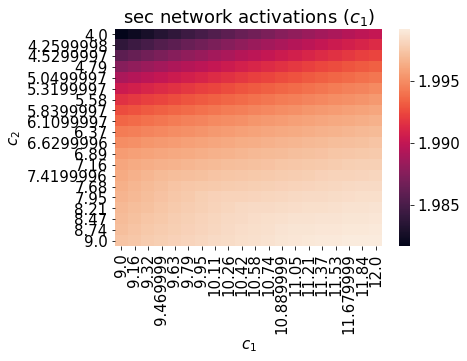

In [158]:
stresses = np.tile(np.linspace(-250, -10, 20), 20)
state_all = fake_cell_state(stresses, chemicals_all, 400)
outputs_all = sec_nn_apply(state_all, opt_params)
sns.heatmap(outputs_all[:, 0].reshape(20,20), xticklabels=np.around(np.linspace(9, 12.0, 20), decimals=2), yticklabels=np.around(np.linspace(4.0, 9.0, 20), decimals=2))
plt.xlabel("$c_1$")
plt.ylabel("$c_2$");
plt.title('sec network activations ($c_1$)');

In [ ]:
opt_params["diffCoeff"]